# Import appropriate modules

In [305]:
import numpy as np
from numpy.linalg import eigh
from numpy.linalg import eig
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

import scipy.constants
from scipy.special import sph_harm

from sympy.physics.wigner import wigner_3j

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define constants

In [306]:
# Physical Constants
HBAR = scipy.constants.hbar

# Molecular Constants
D_MOL = 1.225 * 3.33564e-30  # Molecular dipole moment (C.m)
BROT = 490.173994326310e6 * scipy.constants.h  # BROT := HBAR^2/2I

# Computational Constants
NMAX = 8  #  No. of Rotational base states 0 <= N <= NMAX

EMIN = 0
EMAX = 8  # Max E Field in kV/cm
ESTEPS = 50

# Create empty Hamiltonians
basis order  |0, 0>  |1,-1>  |1, 0>  |1,+1> ....

In [307]:
size = 1 + 2 * NMAX + NMAX**2
# Size of matrix is no. of states, 2N+1 states for each N
Hrot = np.zeros((size, size), dtype=np.cdouble)
Hdc = np.zeros((size, size), dtype=np.cdouble)

# Populate Rotational Hamiltonian

In [308]:
s = 0
for N in range(0, NMAX + 1):
    Erot = BROT * N * (N + 1)
    for M in range(-N, N + 1):
        Hrot[s, s] = Erot
        s += 1

# Populate DC Stark Hamiltonian

In [309]:
i = 0
j = 0
for N1 in range(0, NMAX + 1):
    for M1 in range(-N1, N1 + 1):
        for N2 in range(0, NMAX + 1):
            for M2 in range(-N2, N2 + 1):
                Hdc[i, j] = (
                    -D_MOL
                    * np.sqrt((2 * N1 + 1) * (2 * N2 + 1))
                    * (-1) ** M1
                    * wigner_3j(N1, 1, N2, -M1, 0, M2)
                    * wigner_3j(N1, 1, N2, 0, 0, 0)
                )
                j += 1
        j = 0
        i += 1

# Form and Diagonalise total Hamiltonian

In [310]:
E = np.linspace(EMIN, EMAX, ESTEPS) * 1e5  # V/m
Htot = Hrot[..., None] + Hdc[..., None] * E
Htot = Htot.transpose(2, 0, 1)

energies, states = eigh(Htot)

# Sort states
The `eigh` function sorts the states by increasing energy and so will rearange order of vectors

In [311]:
M = np.matrix([[1,0,0],
               [0,3,0],
               [0,0,2]])

eigval, eigvec = eigh(M)
print("eigen values:\n", eigval)
print("eigen vectors:\n", eigvec)

eigen values:
 [1. 2. 3.]
eigen vectors:
 [[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [312]:
def sort_smooth(energy, states):
    ''' Sort states to remove false avoided crossings.

    This is a function to ensure that all eigenstates plotted change
    adiabatically, it does this by assuming that step to step the eigenstates
    should vary by only a small amount (i.e. that the  step size is fine) and
    arranging states to maximise the overlap one step to the next.

    Args:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy
    Returns:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy E[x,i] -> States[x,:,i]
    '''
    ls = np.arange(states.shape[2],dtype="int")
    number_iterations = len(energy[:,0])
    for i in range(1,number_iterations):
        '''
        This loop sorts the eigenstates such that they maintain some
        continuity. Each eigenstate should be chosen to maximise the overlap
        with the previous.
        '''
        #calculate the overlap of the ith and jth eigenstates
        overlaps = np.einsum('ij,ik->jk',
                                np.conjugate(states[i-1,:,:]),states[i,:,:])
        orig2 = states[i,:,:].copy()
        orig1 = energy[i,:].copy()
        #insert location of maximums into array ls
        np.argmax(np.abs(overlaps),axis=1,out=ls)
        for k in range(states.shape[2]):
            l = ls[k]
            if l!=k:
                energy[i,k] = orig1[l].copy()
                states[i,:,k] = orig2[:,l].copy()
    return energy, states

energies, states = sort_smooth(energies, states)

# Plot Energies against E strength

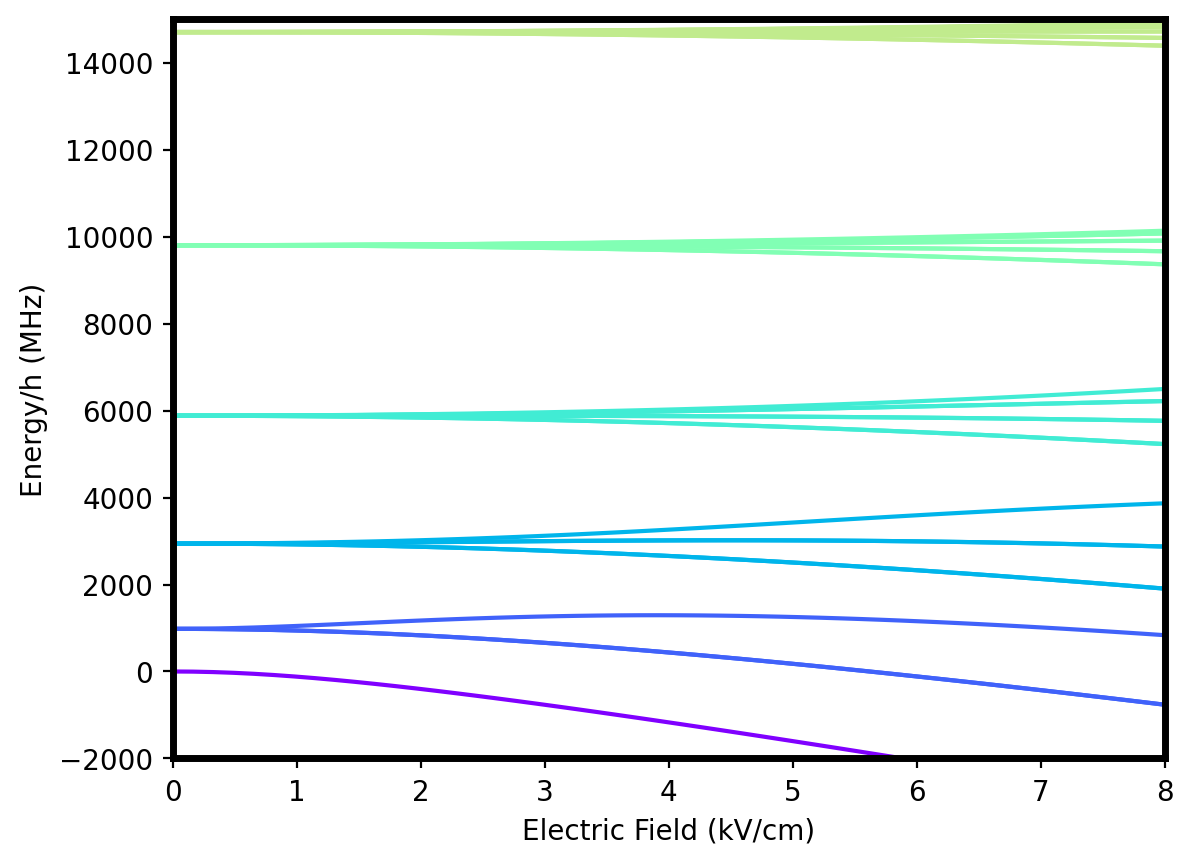

In [313]:
plt.figure()
plt.xlim(0, EMAX)
plt.ylim(-2000, 15000)
plt.ylabel("Energy/h (MHz)")
plt.xlabel("Electric Field (kV/cm)")

color = cm.rainbow(np.linspace(0, 1, NMAX+1))
c=0
n=0
for N in range(0, NMAX + 1):
    for M in range(-N, N + 1):
        plt.plot(E * 1e-5, energies[..., n] * 1e-6 / scipy.constants.h, color=color[c])
        n+=1
    c+=1

plt.show()

# Plot Functions on a Sphere

In [314]:
def f_sph_polar_to_cart_surf(f, resolution=50):
    # Polar and Azimuthal angles to Sample
    theta = np.linspace(0, np.pi, resolution)
    phi = np.linspace(0, 2*np.pi, resolution)
    # Create a 2-D meshgrid of (theta, phi) angles.
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    # Calculate the unit sphere Cartesian coordinates of each (theta, phi).
    xyz = np.array([np.sin(theta_grid) * np.sin(phi_grid), np.sin(theta_grid) * np.cos(phi_grid), np.cos(theta_grid)])
    # Evaluate function over grid
    #f_grid = f(0, 1, phi_grid, theta_grid)
    f_grid = f(theta_grid, phi_grid)
    # get final output cartesian coords
    fxs, fys, fzs = np.abs(f_grid) * xyz
    return fxs, fys, fzs

def surface_plot(fxs, fys, fzs, ax):
    # Add axis lines
    ax_len = 0.5
    ax.plot([-ax_len, ax_len], [0,0], [0,0], c='0.5', lw=1)
    ax.plot([0,0], [-ax_len, ax_len], [0,0], c='0.5', lw=1)
    ax.plot([0,0], [0,0], [-ax_len, ax_len], c='0.5', lw=1)
    # Set axes limits
    ax_lim = 0.5
    ax.set_xlim(-ax_lim, ax_lim)
    ax.set_ylim(-ax_lim, ax_lim)
    ax.set_zlim(-ax_lim, ax_lim)
    # Set camera position
    ax.view_init(elev=20, azim=45) #Reproduce view
    ax.set_xlim3d(-.35,.35)     #Reproduce magnification
    ax.set_ylim3d(-.35,.35)     #...
    ax.set_zlim3d(-.35,.35)     #...
    # Turn off Axes
    ax.axis('off')
    # Draw
    ax.plot_surface(fxs, fys, fzs, rstride=1, cstride=1, cmap=plt.get_cmap('viridis'), linewidth=0, antialiased=False, alpha=0.3, shade=False)

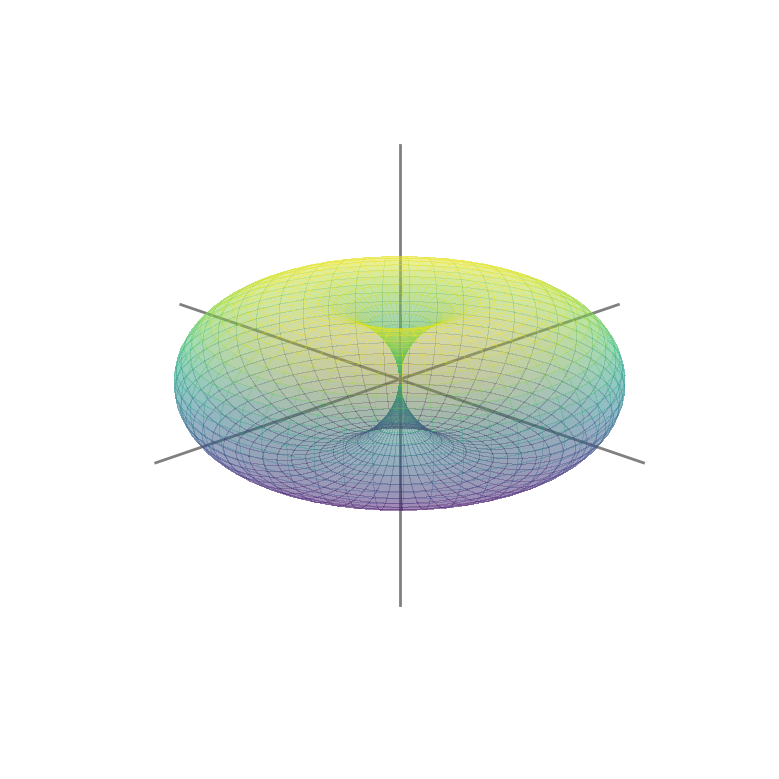

In [315]:
f = lambda theta_grid, phi_grid : sph_harm(1, 1, phi_grid, theta_grid)
fxs, fys, fzs = f_sph_polar_to_cart_surf(f)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface_plot(fxs, fys, fzs, ax)

# Plot the eigenstates under stark shift

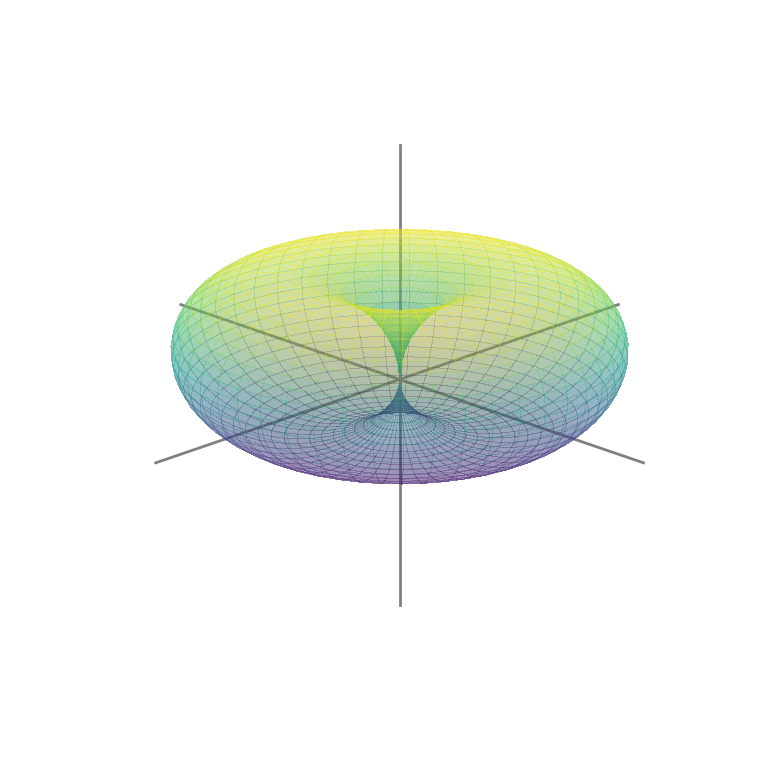

In [318]:
# Grids of polar and azimuthal angles
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2*np.pi, 50)
# Create a 2-D meshgrid of (theta, phi) angles.
theta_grid, phi_grid = np.meshgrid(theta, phi)
# Calculate the unit sphere Cartesian coordinates of each (theta, phi).
xyz = np.array([np.sin(theta_grid) * np.sin(phi_grid), np.sin(theta_grid) * np.cos(phi_grid), np.cos(theta_grid)])

state=3
e_number=EMAX
n=0
f_grid = np.zeros((50, 50), dtype=np.cdouble)
for N in range(0, NMAX + 1):
    for M in range(-N, N + 1):
        coef = states[e_number][:,state][n]
        f_grid += coef * sph_harm(M, N, phi_grid, theta_grid)
        n+=1

# get final output cartesian coords
Yx, Yy, Yz = np.abs(f_grid) * xyz
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surface_plot(Yx, Yy, Yz, ax)

# E shifting Animation

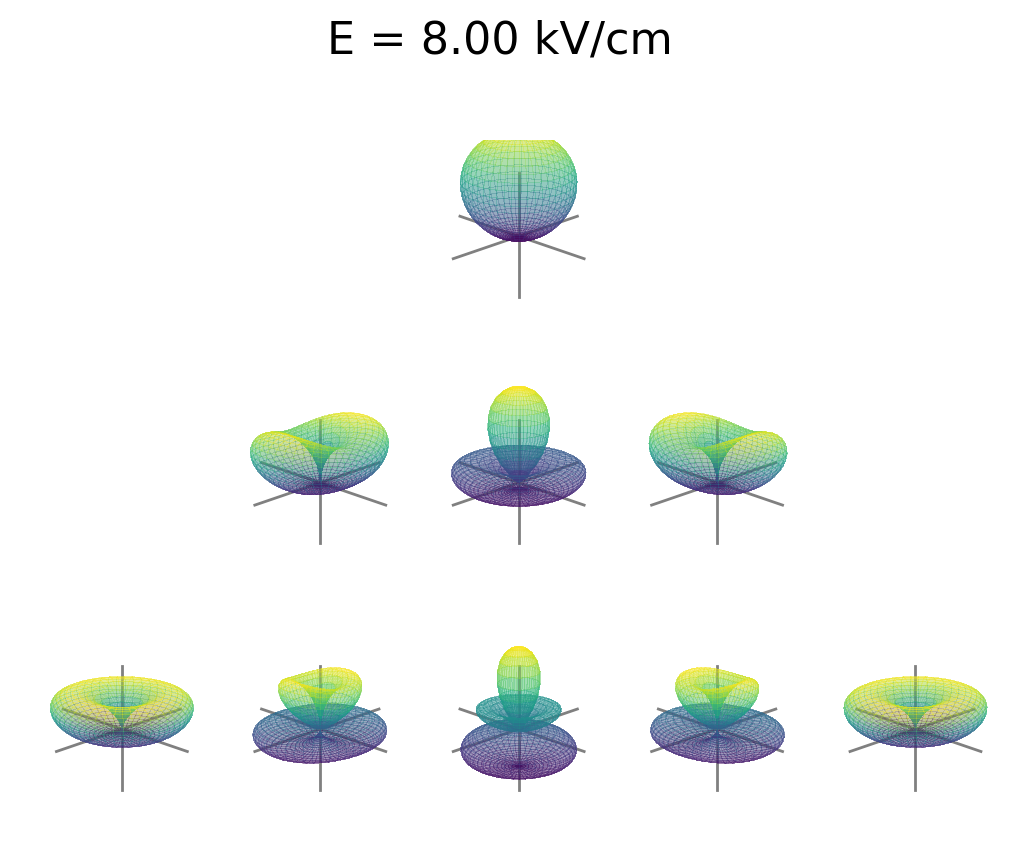

In [317]:
import matplotlib.gridspec as gridspec
el_max = 2

fig = plt.figure()
spec = gridspec.GridSpec(ncols=2*el_max+1, nrows=el_max+1, figure=fig, wspace=0, hspace=0)

# Grids of polar and azimuthal angles
theta = np.linspace(0, np.pi, 50)
phi = np.linspace(0, 2*np.pi, 50)
# Create a 2-D meshgrid of (theta, phi) angles.
theta_grid, phi_grid = np.meshgrid(theta, phi)
# Calculate the unit sphere Cartesian coordinates of each (theta, phi).
xyz = np.array([np.sin(theta_grid) * np.sin(phi_grid), np.sin(theta_grid) * np.cos(phi_grid), np.cos(theta_grid)])

#e_number=0
for e_number in range(ESTEPS):
    fig.clf()
    state=0
    for el in range(el_max+1):
        for m_el in range(-el, el+1):
            ax = fig.add_subplot(spec[el, m_el+el_max], projection='3d')

            n=0
            f_grid = np.zeros((50, 50), dtype=np.cdouble)
            for N in range(0, NMAX + 1):
                for M in range(-N, N + 1):
                    coef = states[e_number][:,state][n]
                    f_grid += coef * sph_harm(M, N, phi_grid, theta_grid)
                    n+=1

            Yx, Yy, Yz = np.abs(f_grid) * xyz
            surface_plot(Yx, Yy, Yz, ax)

            state+=1

    fig.suptitle(f'E = {E[e_number]*1e-5:.2f} kV/cm', fontsize=16)
    filename=f'animation/image{e_number:03}.png'
    fig.savefig(filename, dpi=300)